In [221]:
# Python 3 environment libraries

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')

# Modeling
import statsmodels.api as sm

from scipy.stats import pearsonr
from scipy.stats import iqr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

### Acquire via a .csv file

In [24]:
path = './'

In [276]:
dfproperties_2016 = pd.read_csv(path + 'properties_2016.csv')
print(dfproperties_2016.columns)

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

In [26]:
dftrain_2016 = pd.read_csv(path + 'train_2016.csv')

In [222]:
df_a = pd.DataFrame(dfproperties_2016, columns = [
      'bathroomcnt',
      'bedroomcnt',
      'calculatedfinishedsquarefeet',
      'fullbathcnt',
      'garagecarcnt',
      'regionidzip',
      'roomcnt',
      'yearbuilt',
      'taxvaluedollarcnt',
      'taxamount',
      'parcelid'])

In [223]:
df_b = pd.DataFrame(dftrain_2016, columns = ['parcelid', 'logerror'])

In [251]:
df_join = pd.merge(df_a, df_b, on='parcelid')

In [252]:
variables = pd.DataFrame(df_join.columns, columns=['variable_name'])
variables

,variable_name
0,bathroomcnt
1,bedroomcnt
2,calculatedfinishedsquarefeet
3,fullbathcnt
4,garagecarcnt
5,regionidzip
6,roomcnt
7,yearbuilt
8,taxvaluedollarcnt
9,taxamount


### Sumarize Data

In [253]:
df_join = df_join.apply(lambda x: x.fillna(x.mean()),axis=0)

In [254]:
def summarize_df(df):
    print("\nRows & Columns:\n")
    print(df.shape)
    print("\nColumn Info:\n")
    print(df.info())
    print("\nFirst 5 rows:\n")
    print(df.head())
    print("\nLast 5 rows:\n")
    print(df.tail())
    print("\nMissing Values:\n")
    missing_vals = df.columns[df.isnull().any()]
    print(df.isnull().sum())
    print("\nSummary Stats:\n")
    print(df.describe())
    print("\nColumn IQR:\n")
    var_names = df.columns.values
    for var in var_names:
        print(var+":")
        print(iqr(df[var],axis=0))

In [255]:
summarize_df(df_join)


Rows & Columns:

(90275, 12)

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 12 columns):
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
calculatedfinishedsquarefeet    90275 non-null float64
fullbathcnt                     90275 non-null float64
garagecarcnt                    90275 non-null float64
regionidzip                     90275 non-null float64
roomcnt                         90275 non-null float64
yearbuilt                       90275 non-null float64
taxvaluedollarcnt               90275 non-null float64
taxamount                       90275 non-null float64
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
dtypes: float64(11), int64(1)
memory usage: 9.0 MB
None

First 5 rows:

   bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  fullbathcnt  \
0          2.5         3.0                 

### Data Preparation

In [256]:
df_remove_outliers = df_join[(np.abs(stats.zscore(df_join)) < 3).all(axis=1)]

In [271]:
columns_to_remove = ['regionidzip', 
                     'taxamount', 
                     'fullbathcnt', 
                     'garagecarcnt', 
                     'roomcnt']
df_fixed = df_remove_outliers.drop(columns_to_remove, axis=1)
df_fixed.columns.values

array(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'yearbuilt', 'taxvaluedollarcnt', 'parcelid', 'logerror'],
      dtype=object)

In [272]:
summarize_df(df_fixed)


Rows & Columns:

(84800, 7)

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84800 entries, 0 to 90274
Data columns (total 7 columns):
bathroomcnt                     84800 non-null float64
bedroomcnt                      84800 non-null float64
calculatedfinishedsquarefeet    84800 non-null float64
yearbuilt                       84800 non-null float64
taxvaluedollarcnt               84800 non-null float64
parcelid                        84800 non-null int64
logerror                        84800 non-null float64
dtypes: float64(6), int64(1)
memory usage: 5.2 MB
None

First 5 rows:

   bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  yearbuilt  \
0          2.5         3.0                        1264.0     1986.0   
1          1.0         2.0                         777.0     1990.0   
2          2.0         3.0                        1101.0     1956.0   
3          1.5         2.0                        1554.0     1965.0   
4          2.5         4.0             

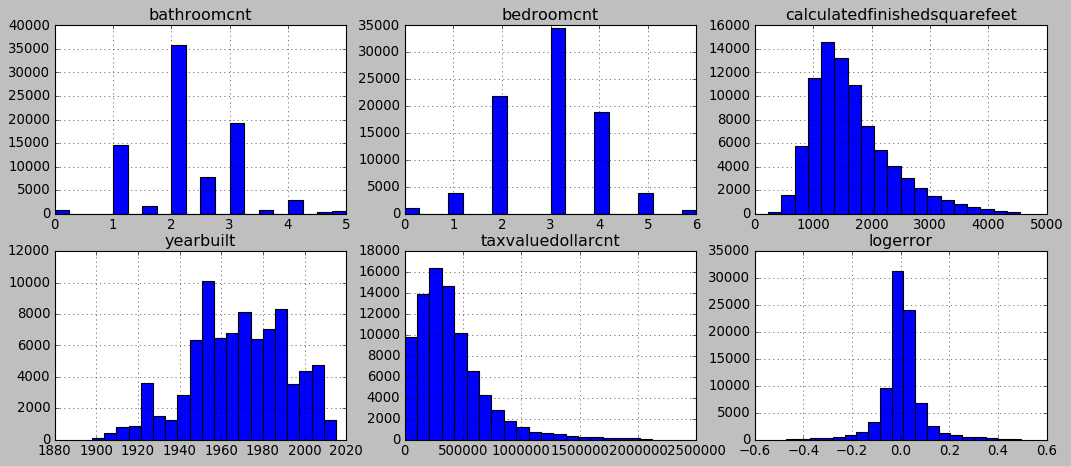

In [273]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(['bathroomcnt', 
                         'bedroomcnt', 
                         'calculatedfinishedsquarefeet', 
                         'yearbuilt',
                         'taxvaluedollarcnt',
                         'logerror']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df_fixed[col]  
    plt.subplot(3, 3, plot_number)
    plt.title(col)
    series.hist(bins=20, density=False, cumulative=False, log=False)

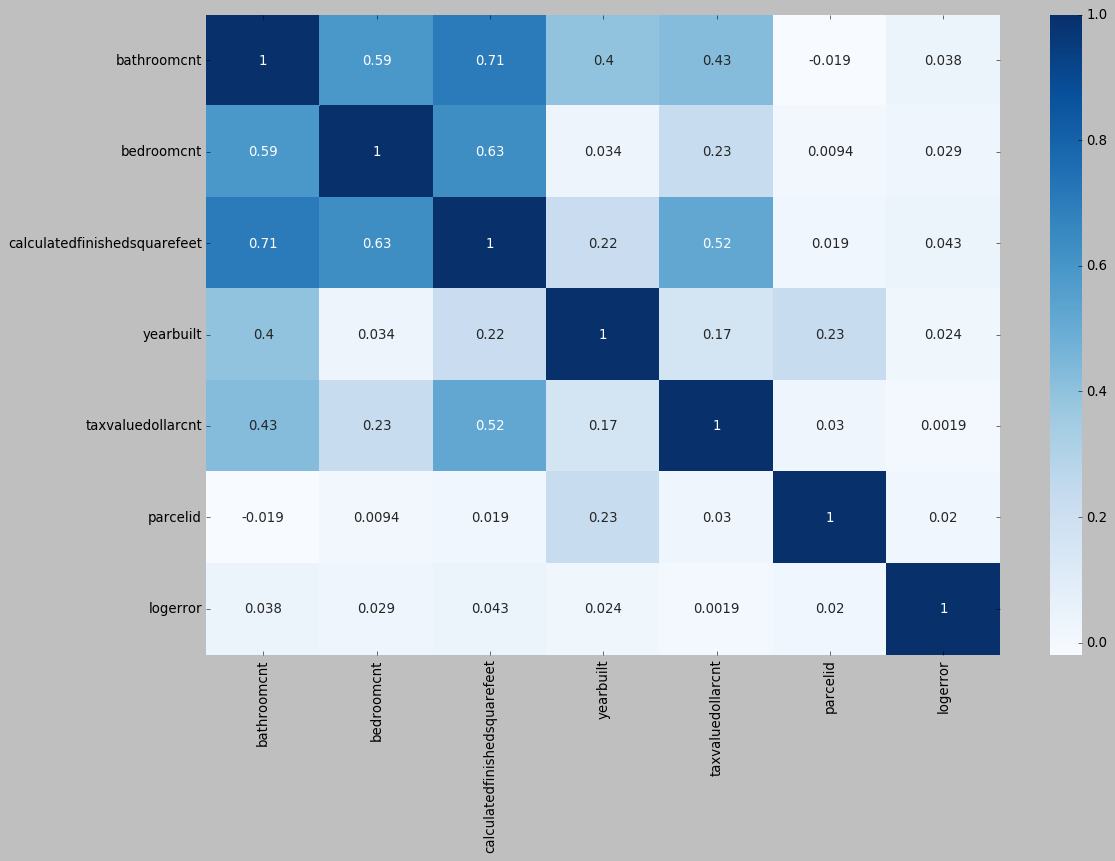

In [274]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_fixed.corr(), cmap='Blues', annot=True)